In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

In [2]:
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)



# AdaBoost(DecisionTreeClassifier)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ Best Params: {'ada__estimator': DecisionTreeClassifier(max_depth=3, min_samples_split=4, random_state=42), 'ada__learning_rate': 0.1, 'ada__n_estimators': 200}

📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


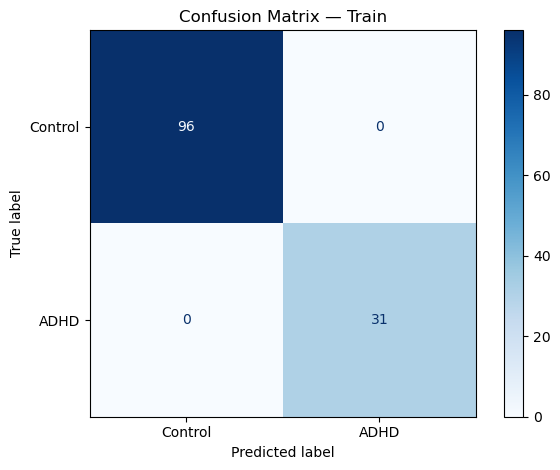

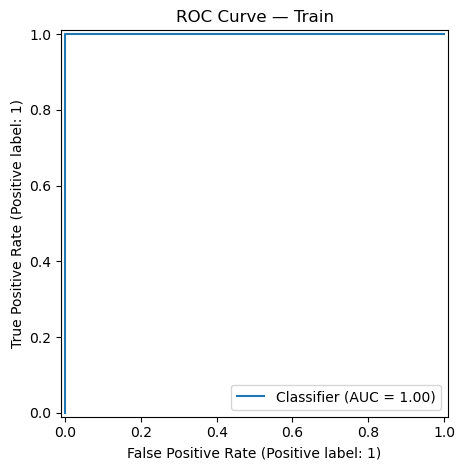

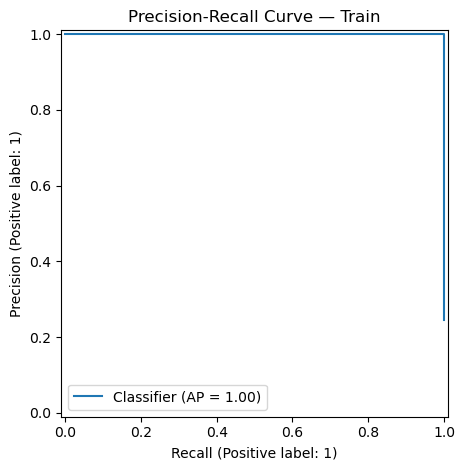

e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\bas


📊 Cross-Validated Scores:
fit_time: 1.0473
score_time: 0.1308
test_accuracy: 0.6796
train_accuracy: 1.0000
test_precision_macro: 0.5136
train_precision_macro: 1.0000
test_recall_macro: 0.5167
train_recall_macro: 1.0000
test_f1_macro: 0.4986
train_f1_macro: 1.0000
test_roc_auc: 0.5493
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.84      0.88      0.86        24
        ADHD       0.57      0.50      0.53         8

    accuracy                           0.78        32
   macro avg       0.71      0.69      0.70        32
weighted avg       0.77      0.78      0.78        32

ROC AUC (Test): 0.7864583333333333


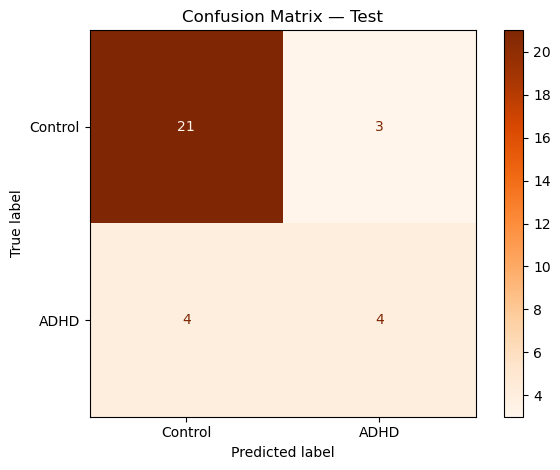

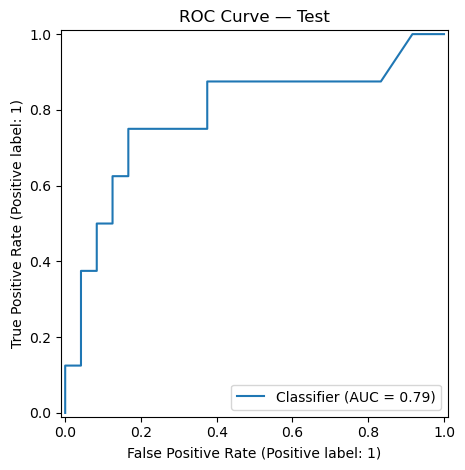

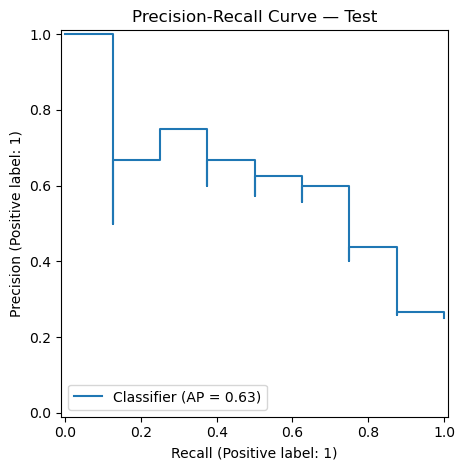

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)

# === Setup CV ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selection ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=16
)

# === AdaBoost Pipeline ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('ada', AdaBoostClassifier(random_state=42))
])

# === Full Param Grid with Base Estimator Variants ===
param_grid = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'ada__estimator': [
        DecisionTreeClassifier(max_depth=d, min_samples_split=m, max_features=f, random_state=42)
        for d in [1, 2, 3]
        for m in [2, 4, 6]
        for f in ['sqrt', 'log2', None]
    ]
}

# === GridSearch ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Training Evaluation ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("\n📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Test Evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test")
plt.tight_layout()
plt.show()


# AdaBoost(LogisticRegression(Elastic))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ Best Parameters: {'ada__estimator': LogisticRegression(C=10, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga'), 'ada__learning_rate': 0.1, 'ada__n_estimators': 50}

📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.83      0.93      0.88        96
        ADHD       0.65      0.42      0.51        31

    accuracy                           0.80       127
   macro avg       0.74      0.67      0.69       127
weighted avg       0.79      0.80      0.79       127

ROC AUC (Train): 0.8508064516129031


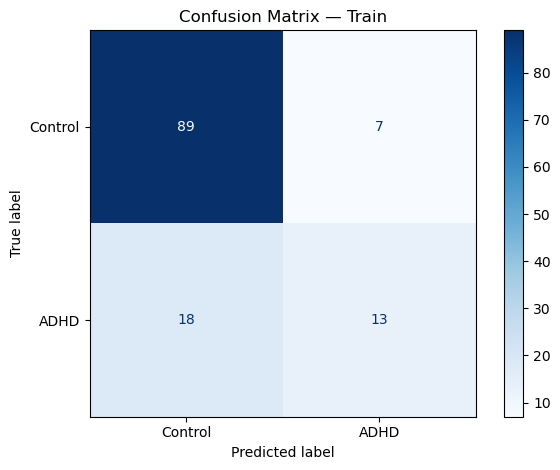

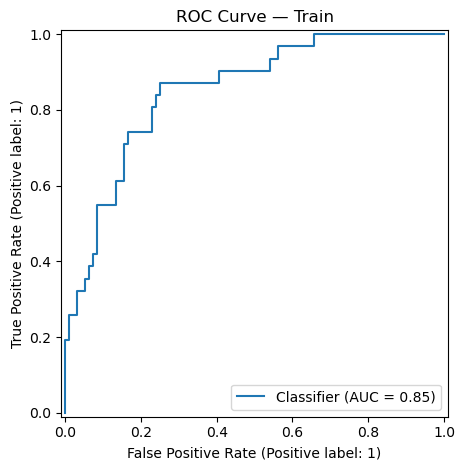

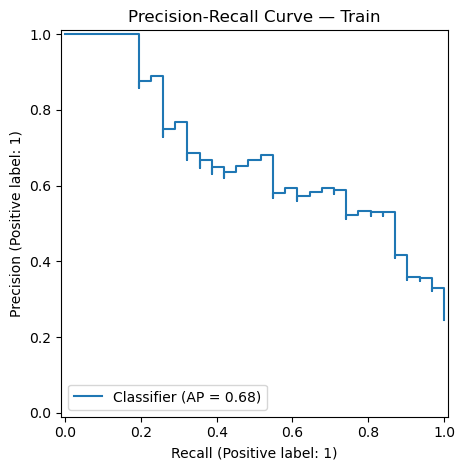

e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\anaconda\envs\bas


📊 Cross-Validated Scores:
fit_time: 2.6173
score_time: 0.0523
test_accuracy: 0.7492
train_accuracy: 0.8141
test_precision_macro: 0.6657
train_precision_macro: 0.7632
test_recall_macro: 0.5833
train_recall_macro: 0.6855
test_f1_macro: 0.5873
train_f1_macro: 0.7077
test_roc_auc: 0.6722
train_roc_auc: 0.8566

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.79      0.96      0.87        24
        ADHD       0.67      0.25      0.36         8

    accuracy                           0.78        32
   macro avg       0.73      0.60      0.62        32
weighted avg       0.76      0.78      0.74        32

ROC AUC (Test): 0.7864583333333334


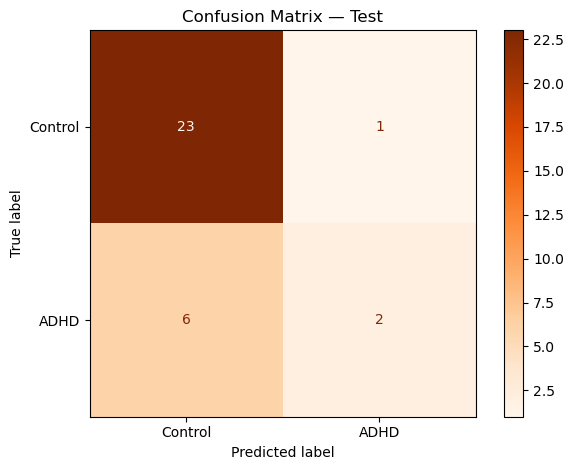

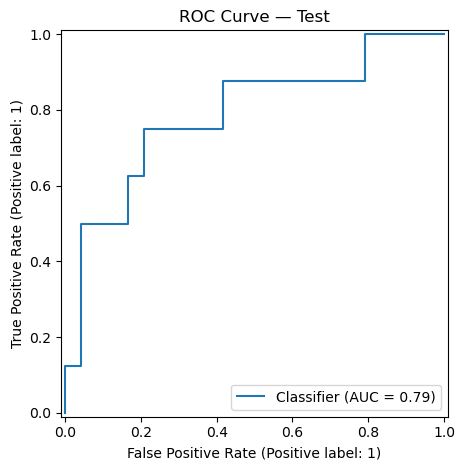

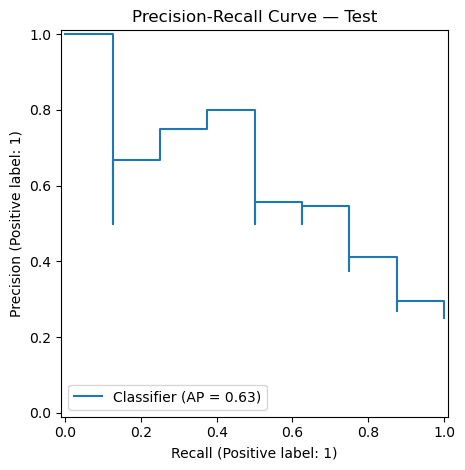

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)

# === Setup Stratified K-Fold CV ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

# === AdaBoost Pipeline ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('ada', AdaBoostClassifier(random_state=42))
])
# === Param Grid: ElasticNet LogisticRegression ===
param_grid = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'ada__estimator': [
        LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            C=c,
            l1_ratio=r,
            max_iter=1000,
            random_state=42
        )
        for c in [0.01, 0.1, 1, 10]
        for r in [0.1, 0.5, 0.9]
    ]
}

# === Grid Search ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit the Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Parameters:", grid_p.best_params_)

# === Predict & Evaluate (Train) ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("\n📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Predict & Evaluate (Test) ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test")
plt.tight_layout()
plt.show()


# RUSBoostClassifier(descision tree) >Random under-sampling integrated in the learning of AdaBoost.

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
168 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
168 fits failed with the following error:
Traceback (most recent call last):
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt,

✅ Best Parameters: {'rus__estimator': DecisionTreeClassifier(max_depth=2, random_state=42), 'rus__learning_rate': 0.5, 'rus__n_estimators': 50}

📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      0.92      0.96        96
        ADHD       0.79      1.00      0.89        31

    accuracy                           0.94       127
   macro avg       0.90      0.96      0.92       127
weighted avg       0.95      0.94      0.94       127

ROC AUC (Train): 0.9885752688172043


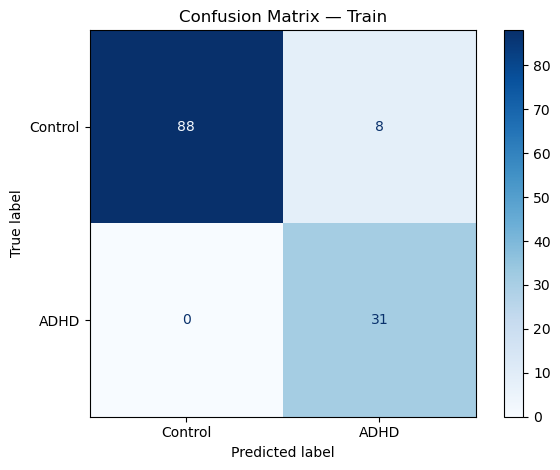

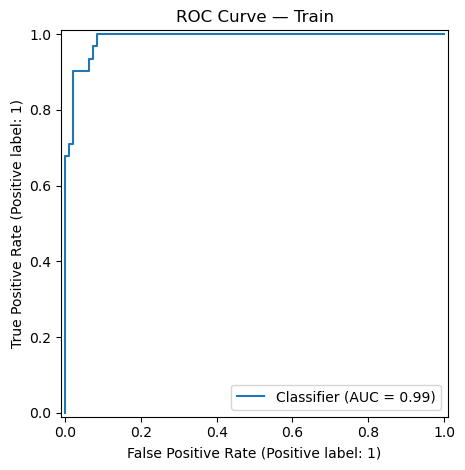

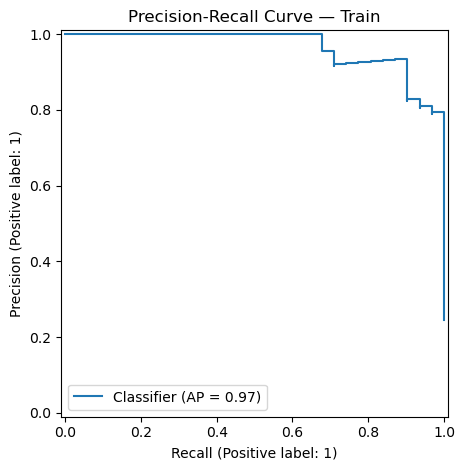

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params


📊 Cross-Validated Scores:
fit_time: 0.3002
score_time: 0.0382
test_accuracy: nan
train_accuracy: nan
test_precision_macro: nan
train_precision_macro: nan
test_recall_macro: nan
train_recall_macro: nan
test_f1_macro: nan
train_f1_macro: nan
test_roc_auc: nan
train_roc_auc: nan

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.77      0.71      0.74        24
        ADHD       0.30      0.38      0.33         8

    accuracy                           0.62        32
   macro avg       0.54      0.54      0.54        32
weighted avg       0.65      0.62      0.64        32

ROC AUC (Test): 0.5885416666666667


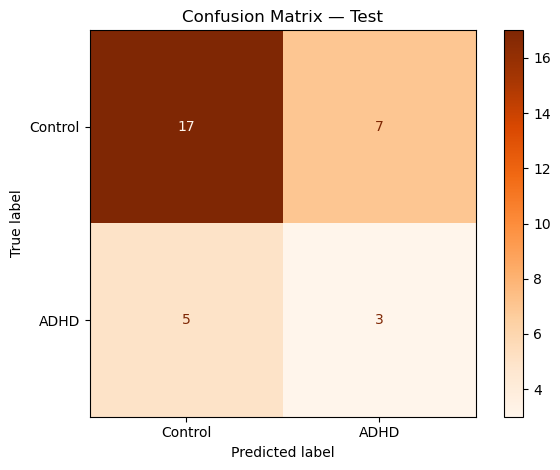

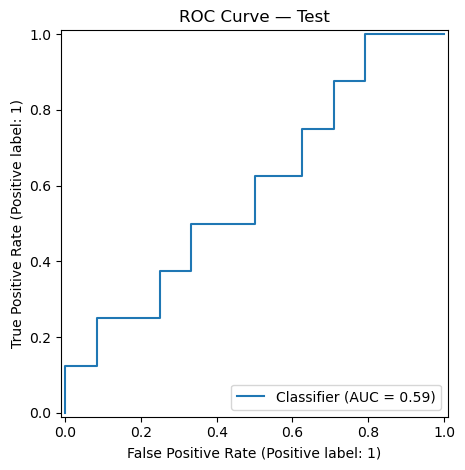

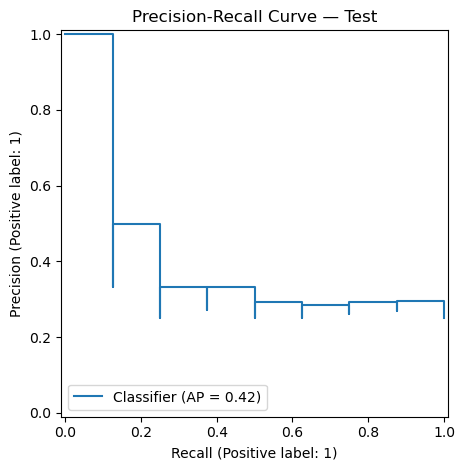

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)

from imblearn.ensemble import RUSBoostClassifier

# === Cross-validation ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature selection using RandomForest ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

# === Pipeline: RUSBoost with Decision Tree ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('rus', RUSBoostClassifier(random_state=42))
])

# === Param grid: tuning Decision Tree as base estimator of RUSBoost ===
param_grid = {
    'rus__n_estimators': [50, 100, 200],
    'rus__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'rus__estimator': [
        DecisionTreeClassifier(
            max_depth=d,
            min_samples_split=s,
            max_features=f,
            random_state=42
        )
        for d in [1, 2, 3]
        for s in [2, 4]
        for f in ['sqrt', 'log2', None]
    ]
}

# === Grid Search ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit the model ===
grid_p.fit(X_train, y_train)
print("✅ Best Parameters:", grid_p.best_params_)

# === Train Evaluation ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("\n📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Test Evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test")
plt.tight_layout()
plt.show()


# RUSBoostClassifier(logistic regression ) >Random under-sampling integrated in the learning of AdaBoost.

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
156 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
156 fits failed with the following error:
Traceback (most recent call last):
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt,

✅ Best Parameters: {'rus__estimator': LogisticRegression(C=10, l1_ratio=0.3, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga'), 'rus__learning_rate': 0.1, 'rus__n_estimators': 50}

📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.92      0.69      0.79        96
        ADHD       0.45      0.81      0.58        31

    accuracy                           0.72       127
   macro avg       0.69      0.75      0.68       127
weighted avg       0.80      0.72      0.74       127

ROC AUC (Train): 0.8397177419354839


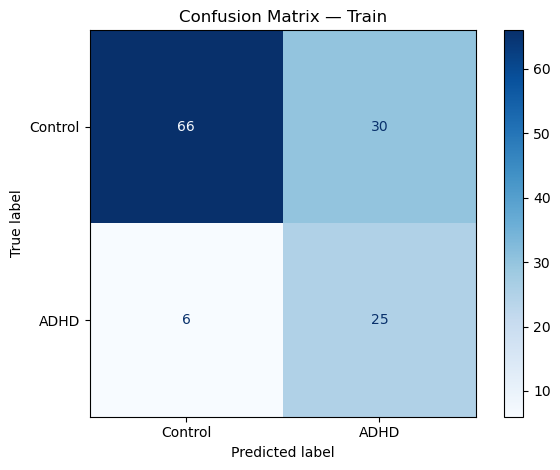

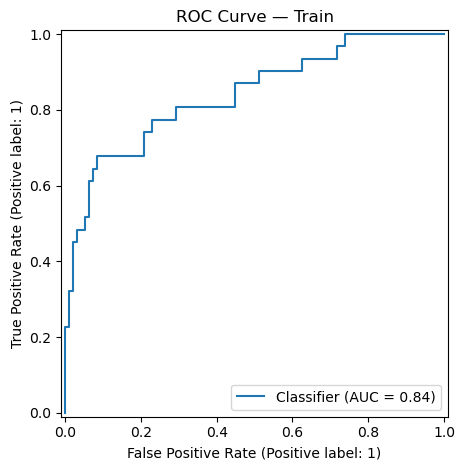

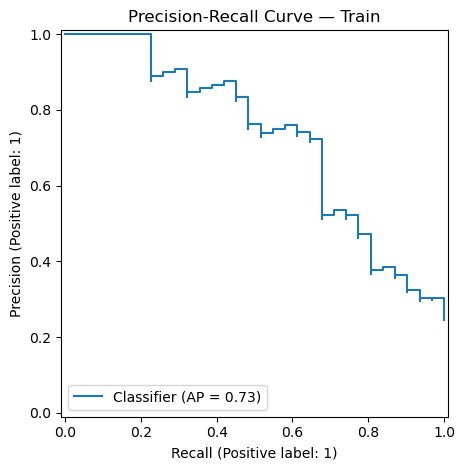

e:\anaconda\envs\basic\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



📊 Cross-Validated Scores:
fit_time: 0.8006
score_time: 0.0436
test_accuracy: 0.5908
train_accuracy: 0.7428
test_precision_macro: 0.5321
train_precision_macro: 0.7000
test_recall_macro: 0.5375
train_recall_macro: 0.7576
test_f1_macro: 0.5164
train_f1_macro: 0.7054
test_roc_auc: 0.6236
train_roc_auc: 0.8464

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.81      0.71      0.76        24
        ADHD       0.36      0.50      0.42         8

    accuracy                           0.66        32
   macro avg       0.59      0.60      0.59        32
weighted avg       0.70      0.66      0.67        32

ROC AUC (Test): 0.7552083333333333


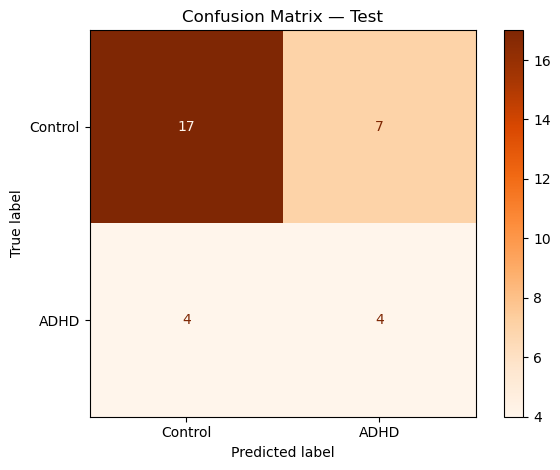

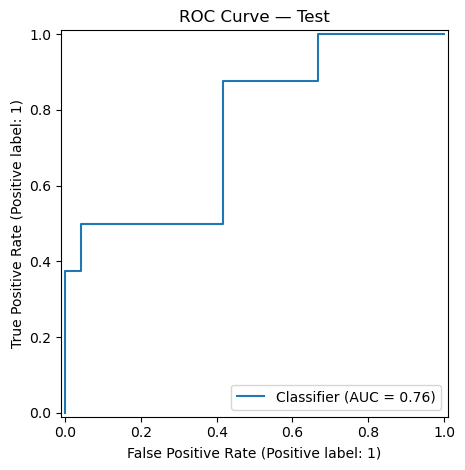

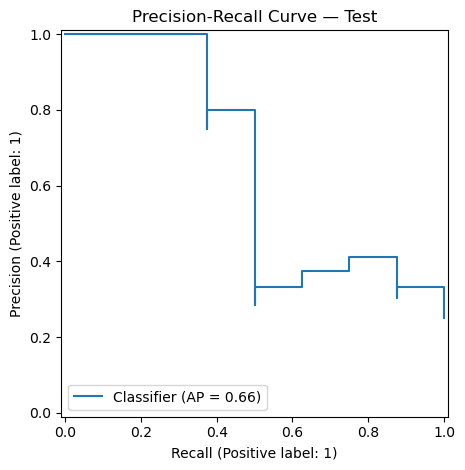

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)

from imblearn.ensemble import RUSBoostClassifier

# === CV ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

# === RUSBoost Pipeline ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('rus', RUSBoostClassifier(random_state=42))
])

# === Param Grid for RUSBoost with Logistic Regression ===
param_grid = {
    'rus__n_estimators': [50, 100, 200],
    'rus__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'rus__estimator': [
        LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            C=c,
            l1_ratio=r,
            max_iter=1000,
            random_state=42
        )
        for c in [0.01, 0.1, 1, 10]
        for r in [0.1,0.3, 0.5, 0.9]
    ]
}

# === GridSearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit the Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Parameters:", grid_p.best_params_)

# === Predict & Evaluate (Train) ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("\n📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Predict & Evaluate (Test) ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test")
plt.tight_layout()
plt.show()


# SequentialFeatureSelector

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

# === Cross-validation strategy ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Sequential Feature Selector ===
# First select top 30 features using SFS with a fast Random Forest
sfs_selector = SequentialFeatureSelector(
    RandomForestClassifier(n_estimators=50, random_state=42),
    n_features_to_select=30,
    direction='forward',
    cv=5,  # Using 5-fold CV for faster feature selection
    n_jobs=-1
)

# === Random Forest for final feature selection ===
rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    max_features=20,
    threshold=-np.inf
)

# === AdaBoost classifier ===
ada = AdaBoostClassifier(random_state=42)

# === Pipeline: SFS -> RF Feature Selection -> AdaBoost ===
pipeline = Pipeline([
    ('sfs_select', sfs_selector),
    ('rf_select', rf_selector),
    ('clf', ada)
])

# === Hyperparameter grid ===
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 1.0]
}

# === Grid Search ===
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='f1',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# === Train ===
grid.fit(X_train_std, y_train)

# === Feature Selection Results ===
# Get features selected by SFS
sfs_support = grid.best_estimator_.named_steps['sfs_select'].get_support()
sfs_features = np.array(X_train.columns)[sfs_support] if hasattr(X_train, 'columns') else [f"Feature_{i}" for i in np.where(sfs_support)[0]]

# Get features selected by RF from the SFS-selected features
rf_support = grid.best_estimator_.named_steps['rf_select'].get_support()
final_features = np.array(sfs_features)[rf_support]

print("\n🔹 Feature Selection Results:")
print(f"Initial features: {X_train_std.shape[1]}")
print(f"After SFS: {len(sfs_features)} features")
print(f"After RF selection: {len(final_features)} features")
print("\n🌟 Final Selected Features:")
print(final_features)

# === Best model & predictions ===
best_model = grid.best_estimator_
y_pred = best_model.predict(X_train_std)
y_proba = best_model.predict_proba(X_train_std)[:, 1]

# === Report ===
print("\n✅ Best Parameters (AdaBoost):", grid.best_params_)
print("\n📘 AdaBoost — Train Set Performance")
print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred, target_names=['Control', 'ADHD']))

# === Confusion Matrix ===
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("AdaBoost — Confusion Matrix (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC Curve ===
print("ROC AUC:", roc_auc_score(y_train, y_proba))
RocCurveDisplay.from_predictions(y_train, y_proba)
plt.title("AdaBoost — ROC Curve (Train)")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
PrecisionRecallDisplay.from_predictions(y_train, y_proba)
plt.title("AdaBoost — Precision-Recall Curve (Train)")
plt.tight_layout()
plt.show()

# === Cross-Validation Evaluation ===
cv_results = cross_validate(
    best_model,
    X_train_std,
    y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for key in cv_results:
    print(f"{key}: {np.mean(cv_results[key]):.4f}")

# === Feature Importances ===
# Get the RandomForest model from the pipeline
rf_model = grid.best_estimator_.named_steps['rf_select'].estimator_

# Get importances for the SFS-selected features
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': sfs_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n🔝 Feature Importances (from RandomForest on SFS-selected features):")
print(importance_df.head(20))